#**Apply LIME to Dog-Cat Classifier**

Mount Google Drive folder.

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Load data using TF Dataset pipelines.

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

base_dir = "drive/My Drive/Teaching/Courses/BA 865/BA865-2022/Week 5/datasets/dogs-vs-cats"
  
train_dataset = image_dataset_from_directory(
    base_dir + "/train/",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    base_dir + "/validation/",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    base_dir + "/test/",
    image_size=(180, 180),
    batch_size=32)

Found 765 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 798 files belonging to 2 classes.


Define model...

In [3]:
from tensorflow import keras 
from keras import layers

data_augmentation = keras.Sequential([
   layers.RandomFlip("horizontal"),
   layers.RandomRotation(0.1),
   layers.RandomZoom(0.2),
])
  
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                             

Fit the model with a callback...

In [4]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="drive/My Drive/Teaching/Courses/BA 865/BA865-2022/Week 5/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/40
24/24 [==============================] - 61s 2s/step - loss: 0.8620 - accuracy: 0.5399 - val_loss: 0.6951 - val_accuracy: 0.5000
Epoch 2/40
24/24 [==============================] - 1s 42ms/step - loss: 0.6916 - accuracy: 0.5163 - val_loss: 0.6894 - val_accuracy: 0.5225
Epoch 3/40
24/24 [==============================] - 1s 47ms/step - loss: 0.6924 - accuracy: 0.5438 - val_loss: 0.6846 - val_accuracy: 0.5925
Epoch 4/40
24/24 [==============================] - 1s 42ms/step - loss: 0.6900 - accuracy: 0.5686 - val_loss: 0.6817 - val_accuracy: 0.6225
Epoch 5/40
24/24 [==============================] - 1s 51ms/step - loss: 0.7345 - accuracy: 0.5725 - val_loss: 0.6747 - val_accuracy: 0.6300
Epoch 6/40
24/24 [==============================] - 1s 43ms/step - loss: 0.6613 - accuracy: 0.6327 - val_loss: 0.6385 - val_accuracy: 0.6300
Epoch 7/40
24/24 [==============================] - 1s 43ms/step - loss: 0.6502 - accuracy: 0.6458 - val_loss: 0.6194 - val_accuracy: 0.6300
Epoch 8/40
24/

As before, this model gets to about 70% accuracy in the test data.

In [5]:
test_model = keras.models.load_model("drive/My Drive/Teaching/Courses/BA 865/BA865-2022/Week 5/convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc}")

25/25 [==============================] - 37s 962ms/step - loss: 0.5557 - accuracy: 0.7343
Test accuracy: 0.7343358397483826


#**LIME Image Explainer**

     |████████████████████████████████| 275 kB 13.7 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=c22527833798bac28c2d9616a806bcf664f55c0d912aa9b4a40639d3cd18665c
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
245760/232316 [===============================] - 1s 3us/step


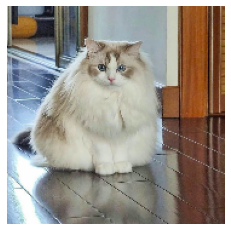

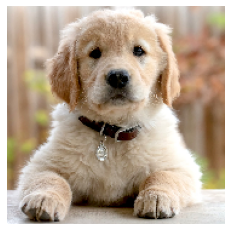

In [6]:
import matplotlib.pyplot as plt
try:
  import lime
  from lime import lime_image
except ImportError as error:
  !pip install lime
  import lime 
  from lime import lime_image

import random
import numpy as np

cat_path = keras.utils.get_file(
    fname="cat6.jpg",
    origin="https://www.brightstarbuddies.com.au/blog/wp-content/uploads/sites/8/Bellamy.jpg")
 
dog_path = keras.utils.get_file(
    fname="dog.jpeg",
    origin="https://kb.rspca.org.au/wp-content/uploads/2018/11/golder-retriever-puppy.jpeg"
)

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array
  
cat_tensor = get_img_array(cat_path, target_size=(180, 180)).astype('double')
dog_tensor = get_img_array(dog_path, target_size=(180, 180)).astype('double')

cat_tensor = np.divide(cat_tensor,255)
dog_tensor = np.divide(dog_tensor,255)

plt.axis("off")
plt.imshow(cat_tensor[0])#.astype("uint8"))
plt.show()
plt.axis("off")
plt.imshow(dog_tensor[0])#.astype("uint8"))
plt.show()

In [7]:
try:
  from skimage.segmentation import mark_boundaries
except ImportError as error:
  !pip install skimage 
  from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Instantiate our LIME explainer.
explainer = lime_image.LimeImageExplainer()

# Now use it to 'explain' the first test image.
explanation = explainer.explain_instance(cat_tensor[0], model.predict, num_samples=1000, top_labels=2, hide_color=1)

print(f'The most probable label for this image is as follows: {explanation.top_labels}.')

  0%|          | 0/1000 [00:00<?, ?it/s]

The most probable label for this image is as follows: [0].


This image was classified as a cat.
The prediction was: [0.00319865]


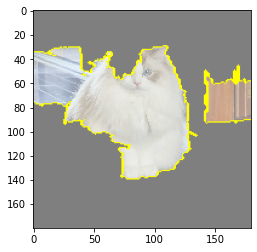

In [10]:
if explanation.top_labels[0]==0:
  print(f'This image was classified as a cat.')
else:
  print(f'This image was classified as a dog.')

print(f'The prediction was: {model.predict(cat_tensor)[0]}')

# positive_only = True means we only display pixels that contributed positively to the respective label. 
# Notice for most labels, the pixel contributions are basically 0.
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, hide_rest=True)
# Add a plot for the associated label 
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()